In [47]:
import pandas as pd
import numpy as np

### Data

In [48]:
data1 = pd.read_csv('../../Data/Jeju/201901-202003.csv')
data1 = data1.fillna('')
data2 = pd.read_csv('../../Data/Jeju/202004.csv')
data2 = data2.fillna('')

In [49]:
data = pd.concat([data1, data2])

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26048114 entries, 0 to 1350321
Data columns (total 12 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   REG_YYMM      int64 
 1   CARD_SIDO_NM  object
 2   CARD_CCG_NM   object
 3   STD_CLSS_NM   object
 4   HOM_SIDO_NM   object
 5   HOM_CCG_NM    object
 6   AGE           object
 7   SEX_CTGO_CD   int64 
 8   FLC           int64 
 9   CSTMR_CNT     int64 
 10  AMT           int64 
 11  CNT           int64 
dtypes: int64(6), object(6)
memory usage: 2.5+ GB


#### 결측 처리

In [51]:
data.loc[data.CARD_CCG_NM.isna(),'CARD_CCG_NM'] = '세종'
data.loc[data.HOM_CCG_NM.isna(),'HOM_CCG_NM'] = '세종'

In [52]:
data

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1350317,202004,충북,충주시,휴양콘도 운영업,충북,충주시,20s,1,1,5,77000,5
1350318,202004,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,6,92000,6
1350319,202004,충북,충주시,휴양콘도 운영업,충북,충주시,40s,2,3,5,193000,5
1350320,202004,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,5,86000,7


#### 18 사업체총조사

In [53]:
all_jobs_df = pd.read_csv('data/18 사업체총조사_키워드매칭.csv',encoding = 'cp949')
all_jobs_df = all_jobs_df[['행정구역별','데이터업종명','사업체수 (개)', '종사자수 (명)']]
all_jobs_df.columns = ['CARD_SIDO_NM','STD_CLSS_NM', 'company','employee']
all_jobs_df.employee = all_jobs_df.employee.apply(lambda x : x.replace("X","0")).astype(int)
all_jobs_df = all_jobs_df.groupby(['CARD_SIDO_NM','STD_CLSS_NM'])[['company','employee']].sum().reset_index()

all_jobs_df = all_jobs_df[~(all_jobs_df.CARD_SIDO_NM == '전국')]

#### 지역내 각 업종이 차지하는 매출비중

In [54]:
def local_percent(data):
    pivoted = data.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    #각 지역별(시군구)업종의 매출비율을 저장
    sidos = pivoted.CARD_SIDO_NM.unique()

    local_percent_df = pd.DataFrame()
    for sido in sidos:
        sample_sido = pivoted[pivoted.CARD_SIDO_NM == sido]
        sigungus = sample_sido.CARD_CCG_NM.unique()
        for sigungu in sigungus:
            sample = sample_sido[sample_sido.CARD_CCG_NM == sigungu]
            sum_arr = sample.iloc[:,3:].sum().values.reshape(1,-1)
            parcent_df = (sample.iloc[:,3:]/sum_arr)*100

            fin = pd.concat([sample.iloc[:,:3],parcent_df],axis=1)
            local_percent_df = pd.concat([local_percent_df,fin])

    #신규변수 LP(local percent) : 지역내 각 업종이 차지하는 매출비중
    local_percent_df = local_percent_df.melt(id_vars=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],value_name='LP')
    return local_percent_df

#### 전체업종에서 각 지역업종이 차지하는 매출비중

In [55]:
def job_percent(data):
    pivoted = data.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    all_pivoted = data.pivot_table(index = ['STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc= 'sum').reset_index()
    all_pivoted.fillna(0,inplace= True)
    all_pivoted = all_pivoted.set_index('STD_CLSS_NM')

    job_percent_df = pd.DataFrame()
    for job in all_pivoted.index:
        taget_df = pivoted[pivoted.STD_CLSS_NM == job]
        tail = (taget_df.iloc[:,3:]/all_pivoted.iloc[0].values)*100
        head = taget_df.iloc[:,:3]
        full = pd.concat([head,tail],axis =1)
        job_percent_df = pd.concat([job_percent_df,full])

    #신규변수 JP(Job percent): 전체업종에서 해당지역의 업종이 차이하는 비율
    job_percent_df = job_percent_df.melt(id_vars=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],value_name='JP')
    return job_percent_df

In [56]:
local_percent_df = local_percent(data)
job_percent_df = job_percent(data)

#### 거래횟수와 이용고객과의 관계 (2019)

In [ ]:
def cust_differ(data):
    data['differ'] = (data.CNT- data.CSTMR_CNT)
    
    #양수(단골)
    plus_custom = data[data['differ']>0]
    pivot_plus = plus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_plus = pivot_plus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='loyal')
    melt_plus['year'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_plus['month'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    
    #2019만 사용
    melt_plus = melt_plus[melt_plus.year == 2019]
    melt_plus.drop(['year'],axis= 1,inplace = True)
    
    #음수(환불)
    minus_custom = data[data['differ']<0]
    pivot_minus = minus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_minus = pivot_minus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='refund')
    melt_minus['year'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_minus['month'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    #2019만 사용
    melt_minus = melt_minus[melt_minus.year == 2019]
    melt_minus.drop(['year'],axis= 1,inplace = True)
    
  
    #둘 결헙
    cust_differ_df = pd.merge(melt_plus,melt_minus,how= 'outer')
    
    return cust_differ_df

In [ ]:
trade_num_2019 = cust_differ(data)

#### 거래횟수와 이용고객과의 관계 (2020)

In [ ]:
def cust_differ_2020(data):
    data['differ'] = (data.CNT- data.CSTMR_CNT)
    
    #양수(단골)
    plus_custom = data[data['differ']>0]
    pivot_plus = plus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_plus = pivot_plus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='loyal')
    melt_plus['year'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_plus['month'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    
    #2020만 사용
    melt_plus = melt_plus[melt_plus.year == 2020]
    melt_plus.drop(['year'],axis= 1,inplace = True)
    
    #음수(환불)
    minus_custom = data[data['differ']<0]
    pivot_minus = minus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_minus = pivot_minus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='refund')
    melt_minus['year'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_minus['month'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    #2020만 사용
    melt_minus = melt_minus[melt_minus.year == 2020]
    melt_minus.drop(['year'],axis= 1,inplace = True)
    
  
    #둘 결헙
    cust_differ_df = pd.merge(melt_plus,melt_minus,how= 'outer')
    
    return cust_differ_df

In [ ]:
trade_num_2020 = cust_differ_2020(data)

In [ ]:
trade_num = pd.concat([trade_num_2019, trade_num_2020])

In [ ]:
trade_num.loyal = trade_num.loyal.fillna(-999)
trade_num.refund = trade_num.refund.fillna(999)

In [ ]:
trade_num

#### 추가변수 결합

In [ ]:
data.shape

In [ ]:
local_percent_df

In [23]:
columns = ['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'HOM_CCG_NM', 'AGE', 'SEX_CTGO_CD', 'FLC']
df = data.groupby(columns, as_index=False)[['AMT']].sum()

In [24]:
grouped = pd.merge(df,all_jobs_df,on =['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
grouped = pd.merge(grouped,local_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','REG_YYMM'],how = 'left')
grouped = pd.merge(grouped,job_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','REG_YYMM'],how = 'left')
grouped = pd.merge(grouped, trade_num, on =['CARD_SIDO_NM','STD_CLSS_NM','REG_YYMM'], how = 'left')

In [25]:
grouped.head(5)

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,1374500,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,818700,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,1717000,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,1047300,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0


In [26]:
grouped.REG_YYMM = pd.to_datetime(grouped.REG_YYMM, format='%Y%m')

In [27]:
from sklearn.preprocessing import LabelEncoder

# 인코딩
dtypes = grouped.dtypes
encoders = {}
for column in grouped.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(grouped[column])
        encoders[column] = encoder
        
df_num = grouped.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(grouped[column])

In [28]:
df_num

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund
0,2019-01-01,0,4,0,0,4,1,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
1,2019-01-01,0,4,0,0,4,2,1,2,1374500,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
2,2019-01-01,0,4,0,0,4,2,2,2,818700,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
3,2019-01-01,0,4,0,0,4,3,1,3,1717000,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
4,2019-01-01,0,4,0,0,4,3,1,4,1047300,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26048109,2020-04-01,16,202,40,16,202,1,1,1,77000,11.0,492.0,0.004580,0.011570,62.0,4.0,999.0
26048110,2020-04-01,16,202,40,16,202,2,1,2,92000,11.0,492.0,0.004580,0.011570,62.0,4.0,999.0
26048111,2020-04-01,16,202,40,16,202,3,2,3,193000,11.0,492.0,0.004580,0.011570,62.0,4.0,999.0
26048112,2020-04-01,16,202,40,16,202,4,1,4,86000,11.0,492.0,0.004580,0.011570,62.0,4.0,999.0


In [29]:
import datetime as dt

df_num['month'] = df_num['REG_YYMM'].dt.month
df_num['year'] = df_num['REG_YYMM'].dt.year

In [30]:
train_df = df_num[df_num['REG_YYMM'] <= '2020-01-01']
validation_df = df_num[(df_num['REG_YYMM'] > '2020-01-01') & (df_num['REG_YYMM'] <'2020-04-01')]

In [31]:
# 7월 데이터 = 2020년의 평균값을 사용.

temp = df_num[df_num['REG_YYMM'] >= '2020']
temp = temp.groupby(['CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM',
                     'HOM_SIDO_NM', 'HOM_CCG_NM', 'AGE', 'SEX_CTGO_CD', 'FLC'], as_index=False)[['company', 'employee', 
                                                            'LP', 'JP', 'loyal', 'month', 'refund', 'year']].mean()

In [32]:
temp.month = 7
temp = pd.concat([df_num[df_num['REG_YYMM'] == '2020-04-01'], temp])

In [33]:
temp = temp.drop(['REG_YYMM', 'AMT'], axis=1)

### Light GBM

In [34]:
import lightgbm as lgb

In [35]:
train_df.head(1)

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund,year
0,2019-01-01,0,4,0,0,4,1,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1,-32.0,2019


In [36]:
train = train_df.drop(['AMT', 'REG_YYMM'], axis=1)
trian_label = np.log1p(train_df[['AMT']])

In [37]:
validation = validation_df.drop(['AMT', 'REG_YYMM'], axis=1)
validation_label = np.log1p(validation_df[['AMT']])

In [38]:
lgb_train = lgb.Dataset(train, label=trian_label)
lgb_eval = lgb.Dataset(validation, label=validation_label, reference=lgb_train)

In [39]:
evals_result = {}
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth':11,
    'num_leaves': 31,
    'learning_rate': 0.5,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0}

In [40]:
model = lgb.train(params, lgb_train, early_stopping_rounds=100,
                  num_boost_round=1000, evals_result=evals_result,
                  valid_sets= (lgb_train, lgb_eval),)

[1]	training's rmse: 1.62817	valid_1's rmse: 1.6457
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 1.5811	valid_1's rmse: 1.60407
[3]	training's rmse: 1.55874	valid_1's rmse: 1.58511
[4]	training's rmse: 1.53092	valid_1's rmse: 1.56065
[5]	training's rmse: 1.51488	valid_1's rmse: 1.54706
[6]	training's rmse: 1.4895	valid_1's rmse: 1.51727
[7]	training's rmse: 1.47909	valid_1's rmse: 1.50698
[8]	training's rmse: 1.46979	valid_1's rmse: 1.49783
[9]	training's rmse: 1.45383	valid_1's rmse: 1.47924
[10]	training's rmse: 1.44598	valid_1's rmse: 1.47105
[11]	training's rmse: 1.44138	valid_1's rmse: 1.46663
[12]	training's rmse: 1.43313	valid_1's rmse: 1.4671
[13]	training's rmse: 1.43091	valid_1's rmse: 1.46613
[14]	training's rmse: 1.42369	valid_1's rmse: 1.45826
[15]	training's rmse: 1.41705	valid_1's rmse: 1.45202
[16]	training's rmse: 1.41442	valid_1's rmse: 1.44933
[17]	training's rmse: 1.4024	valid_1's rmse: 1.43555
[18]	training's rmse: 1.39826	vali

[152]	training's rmse: 1.10719	valid_1's rmse: 1.15509
[153]	training's rmse: 1.10687	valid_1's rmse: 1.15493
[154]	training's rmse: 1.10628	valid_1's rmse: 1.15424
[155]	training's rmse: 1.10577	valid_1's rmse: 1.15379
[156]	training's rmse: 1.10532	valid_1's rmse: 1.15344
[157]	training's rmse: 1.10471	valid_1's rmse: 1.15299
[158]	training's rmse: 1.10437	valid_1's rmse: 1.15281
[159]	training's rmse: 1.104	valid_1's rmse: 1.15247
[160]	training's rmse: 1.10356	valid_1's rmse: 1.15216
[161]	training's rmse: 1.10335	valid_1's rmse: 1.15208
[162]	training's rmse: 1.10284	valid_1's rmse: 1.15172
[163]	training's rmse: 1.10251	valid_1's rmse: 1.15129
[164]	training's rmse: 1.10181	valid_1's rmse: 1.15067
[165]	training's rmse: 1.10157	valid_1's rmse: 1.15062
[166]	training's rmse: 1.09964	valid_1's rmse: 1.14838
[167]	training's rmse: 1.09805	valid_1's rmse: 1.1468
[168]	training's rmse: 1.09716	valid_1's rmse: 1.14594
[169]	training's rmse: 1.09495	valid_1's rmse: 1.14357
[170]	trainin

[302]	training's rmse: 1.01291	valid_1's rmse: 1.06745
[303]	training's rmse: 1.01264	valid_1's rmse: 1.06731
[304]	training's rmse: 1.01232	valid_1's rmse: 1.06722
[305]	training's rmse: 1.01203	valid_1's rmse: 1.06692
[306]	training's rmse: 1.01178	valid_1's rmse: 1.06672
[307]	training's rmse: 1.01128	valid_1's rmse: 1.06633
[308]	training's rmse: 1.01102	valid_1's rmse: 1.06607
[309]	training's rmse: 1.01004	valid_1's rmse: 1.06507
[310]	training's rmse: 1.00986	valid_1's rmse: 1.06486
[311]	training's rmse: 1.0096	valid_1's rmse: 1.06469
[312]	training's rmse: 1.00927	valid_1's rmse: 1.06443
[313]	training's rmse: 1.00914	valid_1's rmse: 1.06436
[314]	training's rmse: 1.00896	valid_1's rmse: 1.06464
[315]	training's rmse: 1.00857	valid_1's rmse: 1.06436
[316]	training's rmse: 1.00802	valid_1's rmse: 1.06391
[317]	training's rmse: 1.0078	valid_1's rmse: 1.06375
[318]	training's rmse: 1.00708	valid_1's rmse: 1.06326
[319]	training's rmse: 1.00668	valid_1's rmse: 1.06284
[320]	traini

[450]	training's rmse: 0.95686	valid_1's rmse: 1.01862
[451]	training's rmse: 0.956751	valid_1's rmse: 1.01857
[452]	training's rmse: 0.956677	valid_1's rmse: 1.0185
[453]	training's rmse: 0.95612	valid_1's rmse: 1.01801
[454]	training's rmse: 0.955692	valid_1's rmse: 1.01763
[455]	training's rmse: 0.95538	valid_1's rmse: 1.01723
[456]	training's rmse: 0.955197	valid_1's rmse: 1.01706
[457]	training's rmse: 0.955007	valid_1's rmse: 1.01696
[458]	training's rmse: 0.954728	valid_1's rmse: 1.01671
[459]	training's rmse: 0.954535	valid_1's rmse: 1.01663
[460]	training's rmse: 0.953965	valid_1's rmse: 1.01631
[461]	training's rmse: 0.953456	valid_1's rmse: 1.01575
[462]	training's rmse: 0.952861	valid_1's rmse: 1.0152
[463]	training's rmse: 0.952738	valid_1's rmse: 1.01517
[464]	training's rmse: 0.952308	valid_1's rmse: 1.01475
[465]	training's rmse: 0.952207	valid_1's rmse: 1.01461
[466]	training's rmse: 0.951596	valid_1's rmse: 1.01383
[467]	training's rmse: 0.951178	valid_1's rmse: 1.013

[596]	training's rmse: 0.914884	valid_1's rmse: 0.981675
[597]	training's rmse: 0.914633	valid_1's rmse: 0.981466
[598]	training's rmse: 0.914308	valid_1's rmse: 0.981158
[599]	training's rmse: 0.91406	valid_1's rmse: 0.980935
[600]	training's rmse: 0.913973	valid_1's rmse: 0.980856
[601]	training's rmse: 0.91392	valid_1's rmse: 0.98137
[602]	training's rmse: 0.913709	valid_1's rmse: 0.981204
[603]	training's rmse: 0.913565	valid_1's rmse: 0.981089
[604]	training's rmse: 0.913198	valid_1's rmse: 0.9809
[605]	training's rmse: 0.912876	valid_1's rmse: 0.98057
[606]	training's rmse: 0.91279	valid_1's rmse: 0.98053
[607]	training's rmse: 0.912406	valid_1's rmse: 0.980069
[608]	training's rmse: 0.912313	valid_1's rmse: 0.979971
[609]	training's rmse: 0.912063	valid_1's rmse: 0.979136
[610]	training's rmse: 0.912007	valid_1's rmse: 0.979097
[611]	training's rmse: 0.911929	valid_1's rmse: 0.979076
[612]	training's rmse: 0.91182	valid_1's rmse: 0.97899
[613]	training's rmse: 0.911603	valid_1's

[741]	training's rmse: 0.889174	valid_1's rmse: 0.962569
[742]	training's rmse: 0.889048	valid_1's rmse: 0.962433
[743]	training's rmse: 0.888805	valid_1's rmse: 0.962308
[744]	training's rmse: 0.888555	valid_1's rmse: 0.962195
[745]	training's rmse: 0.888455	valid_1's rmse: 0.962091
[746]	training's rmse: 0.888293	valid_1's rmse: 0.96203
[747]	training's rmse: 0.887842	valid_1's rmse: 0.961586
[748]	training's rmse: 0.887666	valid_1's rmse: 0.96148
[749]	training's rmse: 0.887586	valid_1's rmse: 0.96139
[750]	training's rmse: 0.887414	valid_1's rmse: 0.9613
[751]	training's rmse: 0.887274	valid_1's rmse: 0.961148
[752]	training's rmse: 0.886986	valid_1's rmse: 0.960808
[753]	training's rmse: 0.886955	valid_1's rmse: 0.960789
[754]	training's rmse: 0.886834	valid_1's rmse: 0.96065
[755]	training's rmse: 0.886697	valid_1's rmse: 0.960568
[756]	training's rmse: 0.886636	valid_1's rmse: 0.960576
[757]	training's rmse: 0.886437	valid_1's rmse: 0.960351
[758]	training's rmse: 0.886364	valid

[886]	training's rmse: 0.868678	valid_1's rmse: 0.946624
[887]	training's rmse: 0.868477	valid_1's rmse: 0.946547
[888]	training's rmse: 0.868291	valid_1's rmse: 0.946284
[889]	training's rmse: 0.868253	valid_1's rmse: 0.946255
[890]	training's rmse: 0.868207	valid_1's rmse: 0.94606
[891]	training's rmse: 0.868158	valid_1's rmse: 0.946065
[892]	training's rmse: 0.868067	valid_1's rmse: 0.946015
[893]	training's rmse: 0.867951	valid_1's rmse: 0.945893
[894]	training's rmse: 0.867774	valid_1's rmse: 0.945724
[895]	training's rmse: 0.867567	valid_1's rmse: 0.945555
[896]	training's rmse: 0.867513	valid_1's rmse: 0.94548
[897]	training's rmse: 0.867472	valid_1's rmse: 0.945439
[898]	training's rmse: 0.867338	valid_1's rmse: 0.945401
[899]	training's rmse: 0.867251	valid_1's rmse: 0.945334
[900]	training's rmse: 0.867127	valid_1's rmse: 0.945158
[901]	training's rmse: 0.867048	valid_1's rmse: 0.945151
[902]	training's rmse: 0.866909	valid_1's rmse: 0.945091
[903]	training's rmse: 0.866849	v

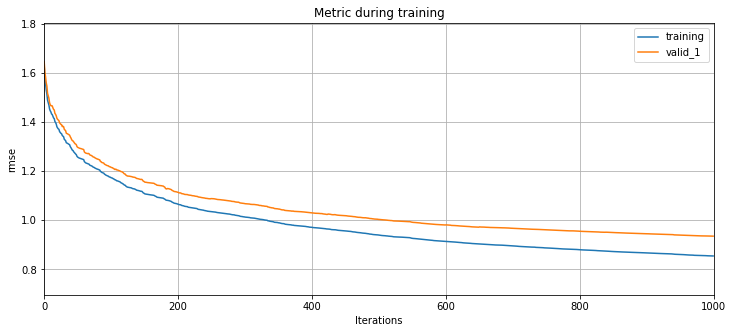

In [41]:
import matplotlib as mlt
import matplotlib.pyplot as plt
%matplotlib inline

lgb.plot_metric(evals_result, figsize=(12, 5))

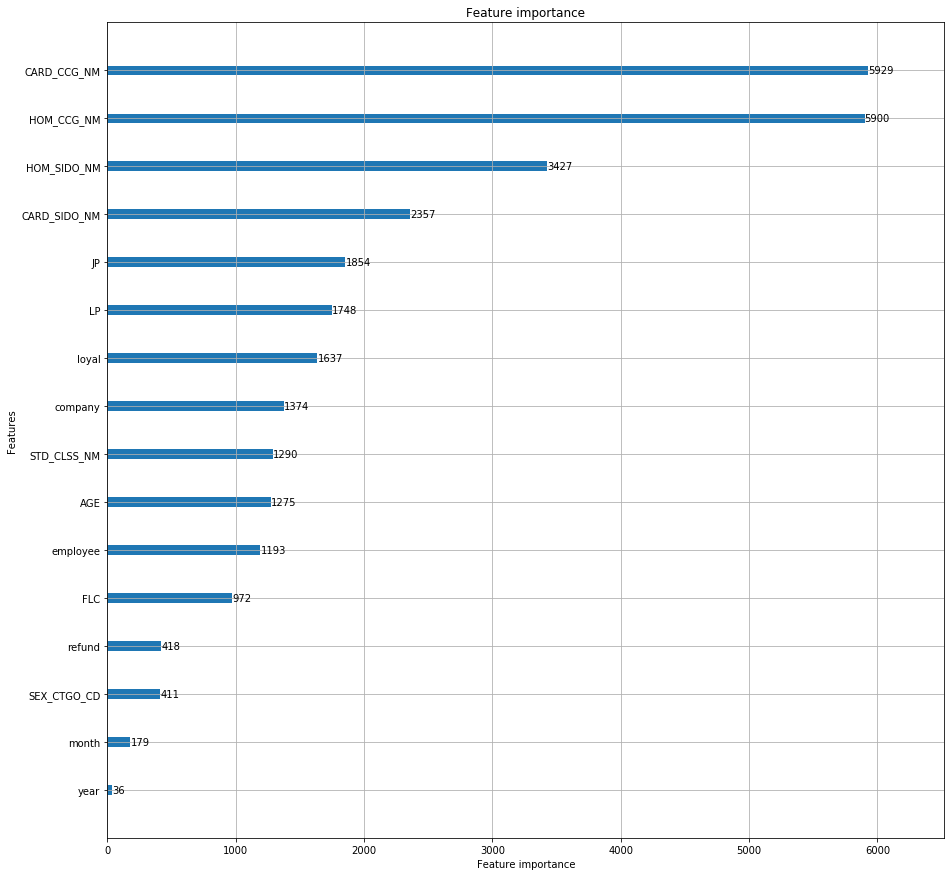

In [42]:
lgb.plot_importance(model, figsize=(15,15))

In [43]:
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [44]:
# 디코딩 (Random Forest)
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [45]:
# 제출 파일 만들기(Random Forest)
submission = pd.read_csv('../../Data/Jeju/submission.csv', index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'
compare_pred = submission.dropna()
submission = submission.fillna(0)
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,6.804327e+07
1,202004,강원,골프장 운영업,2.753227e+09
2,202004,강원,과실 및 채소 소매업,8.560709e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,1.326185e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00


In [46]:
submission.to_csv('submission/submission lgbm 0730 all location.csv', encoding='utf-8-sig')